
# Ridge Regression – Migration Project (Quick Student Notebook)

This notebook runs a **Ridge regression** on the migration panel data using `sklearn`,
with a **time-based train/test split** and a short, informal interpretation in French.


In [4]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ===================================================================
# 1. LOAD DATA
# ===================================================================

DATA_PATH = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/data/databasecsv.csv")

def load_data(path=DATA_PATH):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path.resolve()}")
    df = pd.read_csv(path, sep=";")
    df.columns = df.columns.str.strip()
    return df

df = load_data()
print("Loaded dataset:", df.shape)


# ===================================================================
# 2. PREPARE DATAFRAME (LAG + INTERACTIONS + DUMMIES)
# ===================================================================

def prepare_dataframe(df):

    # canton IDs + lag
    df["canton_id"] = df["canton"].astype("category").cat.codes
    df["migration_lag1"] = df.groupby("canton_id")["migration_rate"].shift(1)

    # base features
    base_vars = [
        "Z_score_rent",
        "avg_income_zscore",
        "z-score_unemployment",
        "shockexposure_zscore",
        "CLUSTER1",
        "CLUSTER2",
        "migration_lag1",
    ]

    # interactions
    df["avg_income_zscore_x_Z_score_rent"] = df["avg_income_zscore"] * df["Z_score_rent"]
    df["z-score_unemployment_x_avg_income_zscore"] = df["z-score_unemployment"] * df["avg_income_zscore"]
    df["schockexposure_x_CLUSTER1"] = df["shockexposure_zscore"] * df["CLUSTER1"]
    df["schockexposure_x_CLUSTER2"] = df["shockexposure_zscore"] * df["CLUSTER2"]

    interaction_vars = [
        "avg_income_zscore_x_Z_score_rent",
        "z-score_unemployment_x_avg_income_zscore",
        "schockexposure_x_CLUSTER1",
        "schockexposure_x_CLUSTER2",
    ]

    required_cols = ["migration_rate", "canton", "year"] + base_vars + interaction_vars
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    df_model = df.dropna(subset=required_cols).copy()
    print("After cleaning:", df_model.shape)

    # dummies canton
    df_model = pd.get_dummies(df_model, columns=["canton"], drop_first=True)

    # year numeric
    df_model["year"] = pd.to_numeric(df_model["year"], errors="coerce")

    # final feature list
    canton_cols = [c for c in df_model.columns if c.startswith("canton_")]
    feature_cols = base_vars + interaction_vars + canton_cols

    # enforce numeric
    df_model[feature_cols] = df_model[feature_cols].apply(pd.to_numeric, errors="coerce")
    df_model["migration_rate"] = pd.to_numeric(df_model["migration_rate"], errors="coerce")

    if df_model[feature_cols].isna().any().any():
        raise ValueError("NaN values in features after conversion.")

    return df_model, feature_cols

df_model, feature_cols = prepare_dataframe(df)


# ===================================================================
# 3. TIME-BASED TRAIN/TEST SPLIT
# ===================================================================

def time_split(df_model, feature_cols):

    df_sorted = df_model.sort_values("year").reset_index(drop=True)
    years = df_sorted["year"].unique()

    cut = int(0.8 * len(years))
    train_years = set(years[:cut])
    test_years  = set(years[cut:])

    X_train = df_sorted.loc[df_sorted["year"].isin(train_years), feature_cols].to_numpy()
    y_train = df_sorted.loc[df_sorted["year"].isin(train_years), "migration_rate"].to_numpy()

    X_test  = df_sorted.loc[df_sorted["year"].isin(test_years),  feature_cols].to_numpy()
    y_test  = df_sorted.loc[df_sorted["year"].isin(test_years),  "migration_rate"].to_numpy()

    print("Train:", X_train.shape, "Test:", X_test.shape)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = time_split(df_model, feature_cols)


# ===================================================================
# 4. RIDGE WITH CROSS-VALIDATION ON λ
# ===================================================================

def run_ridge(X_train, y_train, X_test, y_test, alphas):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    best_alpha = None
    best_r2 = -np.inf
    best_model = None
    results = []

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_pred_train = model.predict(X_train_scaled)
        y_pred_test  = model.predict(X_test_scaled)

        r2_train = r2_score(y_train, y_pred_train)
        r2_test  = r2_score(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)

        results.append((alpha, mse_test, r2_train, r2_test))

        if r2_test > best_r2:
            best_r2 = r2_test
            best_alpha = alpha
            best_model = model

    return best_model, best_alpha, best_r2, results, scaler

alphas = [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
best_model, best_alpha, best_r2, results, scaler = run_ridge(
    X_train, y_train, X_test, y_test, alphas
)


# ===================================================================
# 5. FINAL OUTPUT — SAME AS YOUR .PY SCRIPT
# ===================================================================

print("\n=== BEST RIDGE MODEL ===")
print("Best λ:", best_alpha)
print("Best Test R²:", best_r2)

# recompute scaled features
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train/Test R²
train_r2 = r2_score(y_train, best_model.predict(X_train_scaled))
test_r2  = r2_score(y_test,  best_model.predict(X_test_scaled))

print(f"Train R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")

# coefficients
coefs = best_model.coef_

coef_table = pd.DataFrame({
    "feature": feature_cols,
    "coef": coefs
}).sort_values("coef", key=abs, ascending=False)

coef_table


Loaded dataset: (285, 38)
After cleaning: (234, 44)
Train: (182, 37) Test: (52, 37)

=== BEST RIDGE MODEL ===
Best λ: 10.0
Best Test R²: 0.6093685898180203
Train R²: 0.7609
Test  R²: 0.6094


,feature,coef
16,canton_BS,-0.130960
23,canton_NE,-0.085600
0,Z_score_rent,0.083759
17,canton_FR,0.076904
7,avg_income_zscore_x_Z_score_rent,-0.075376
18,canton_GE,-0.055782
5,CLUSTER2,-0.048946
20,canton_GR,-0.046219
34,canton_VS,0.045994
6,migration_lag1,0.044654


ROOT added to sys.path: /Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics
y_pred_best OK : [ 0.05458493 -0.00054951  0.45454489  0.25478739 -0.10731977]


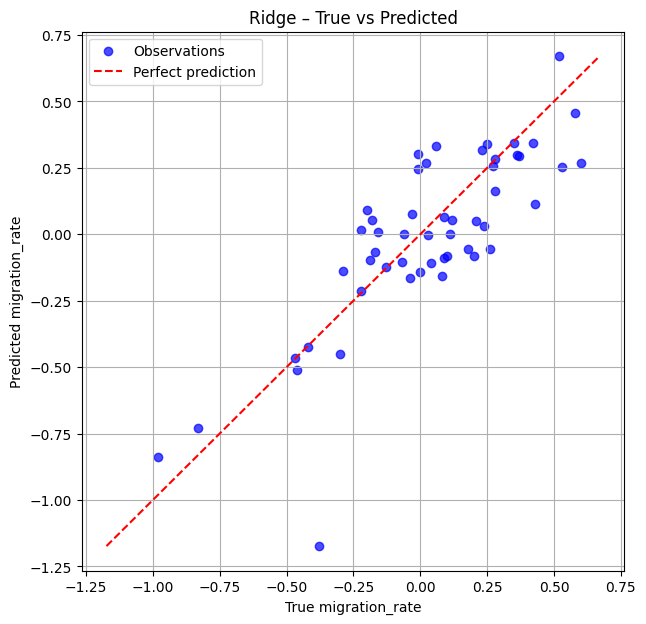

In [7]:
from pathlib import Path
import sys

ROOT = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics")
sys.path.append(str(ROOT))

print("ROOT added to sys.path:", ROOT)

# regenerate test predictions
X_test_scaled = scaler.transform(X_test)
y_pred_best = best_model.predict(X_test_scaled)

print("y_pred_best OK :", y_pred_best[:5])


from src.ML.ridge.plotridge import plot_true_vs_pred

plot_true_vs_pred(y_test, y_pred_best)
